
# Projet : Classification d’images MNIST bruitées - Mélina Farshchi


In [ ]:

# === Installation / Imports ===
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_curve, roc_curve, auc,
                             roc_auc_score, average_precision_score)
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import plot_model



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

print("TF:", tf.__version__, "Keras:", keras.__version__)
np.random.seed(42)
tf.random.set_seed(42)


TF: 2.19.0 Keras: 3.10.0


## Chargement des données

In [ ]:
# === Accès Google Drive ===
from google.colab import drive
drive.mount("/content/drive")

# Définir ton dossier de projet
%cd /content/drive/MyDrive
%mkdir -p M2BI_DRIVE
%cd M2BI_DRIVE
%pwd

# Chemins des fichiers dans le Drive
FN_TRAIN_X = "/content/drive/MyDrive/M2BI_DRIVE/train_images.npy"
FN_TRAIN_Y = "/content/drive/MyDrive/M2BI_DRIVE/train_labels.npy"
FN_TEST_X  = "/content/drive/MyDrive/M2BI_DRIVE/test_images.npy"
FN_TEST_Y  = "/content/drive/MyDrive/M2BI_DRIVE/test_labels.npy"

# Charger directement
train_images = np.load(FN_TRAIN_X)
train_labels = np.load(FN_TRAIN_Y)
test_images  = np.load(FN_TEST_X)
test_labels  = np.load(FN_TEST_Y)

print("Shapes:")
print("train_images:", train_images.shape, "train_labels:", train_labels.shape)
print("test_images :", test_images.shape,  "test_labels :", test_labels.shape)


Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/M2BI_DRIVE
Shapes:
train_images: (60000, 28, 28, 1) train_labels: (60000,)
test_images : (10000, 28, 28, 1) test_labels : (10000,)


## Format du dataset

train_images: (60000, 28, 28, 1) :
*   60 000 = nb d'images dans l'ensemble dentraînement (train_set).
*   28x28 = taille en pixels de chaque image.
*   1 = nombre de canaux (ici 1 seul ➡ niveaux de gris).

train_labels: (60000,) :    
* Vecteur des étiquettes (labels) associé aux images d'entraînement. Chaque valeur est le chiffre manuscrit représenté.

test_images: (10000, 28, 28, 1) :
* 10 000 images, même format (28x28,  canal) mais pour le jeu de test.

test_labels: (10000,) :
* Les étiquettes correspondantes pour les images du test.



---



Vérification des dimensions des images dans train et test.

In [ ]:
# Petites vérifs
assert train_images.ndim == 4 and train_images.shape[1:] == (28, 28, 1)
assert test_images.ndim  == 4 and test_images.shape[1:]  == (28, 28, 1)
assert train_labels.ndim == 1 and test_labels.ndim == 1
assert set(np.unique(train_labels)).issubset(set(range(10)))
assert set(np.unique(test_labels)).issubset(set(range(10)))

Vérification du format des images, visiblement le train a été normalisé par 255 alors que le test non.

In [ ]:
print("=== Avant normalisation ===")
print("train_images :", train_images.shape, train_images.dtype,
      "min=", train_images.min(), "max=", train_images.max())
print("test_images  :", test_images.shape, test_images.dtype,
      "min=", test_images.min(), "max=", test_images.max())


=== Avant normalisation ===
train_images : (60000, 28, 28, 1) float32 min= 0.0 max= 1.0
test_images  : (10000, 28, 28, 1) uint8 min= 0 max= 255


## Etapes de pré-processing

In [ ]:
# === Étape 1 : format & prétraitement ===

# Mise à l’échelle cohérente (détecte automatiquement si besoin)
def to_float01(x):
    """x -> float32 dans [0,1] si max>1 (données 0..255)."""
    x = x.astype("float32", copy=False)
    if x.max() > 1.0:
        x /= 255.0
    return x

# Normalisation UNE FOIS sur les tenseurs 4D (source pour tout le reste)
X_all_4d  = to_float01(train_images)   # (60000,28,28,1) float32 [0,1]
X_test_4d = to_float01(test_images)    # (10000,28,28,1) float32 [0,1]

# Vues dérivées pour chaque modèle
#    - CNN: on garde 4D
#    - MLP: on aplati en 2D (784)
X_all_cnn  = X_all_4d                                 # (60000,28,28,1)
X_test_cnn = X_test_4d                                # (10000,28,28,1)
X_all_flat  = X_all_4d.reshape((-1, 28*28))           # (60000,784)
X_test_flat = X_test_4d.reshape((-1, 28*28))          # (10000,784)

# Labels (entiers)
y_all  = train_labels.astype("int64", copy=False)
y_test = test_labels.astype("int64",  copy=False)

# Sanity checks
def describe(name, x):
    x_min, x_max = float(x.min()), float(x.max())
    print(f"{name}: shape={x.shape}, dtype={x.dtype}, min={x_min:.3f}, max={x_max:.3f}")

describe("X_all_4d",  X_all_4d)
describe("X_test_4d", X_test_4d)
describe("X_all_flat",  X_all_flat)
describe("X_test_flat", X_test_flat)
print("y_all:", y_all.shape, "| y_test:", y_test.shape)

X_all_4d: shape=(60000, 28, 28, 1), dtype=float32, min=0.000, max=1.000
X_test_4d: shape=(10000, 28, 28, 1), dtype=float32, min=0.000, max=1.000
X_all_flat: shape=(60000, 784), dtype=float32, min=0.000, max=1.000
X_test_flat: shape=(10000, 784), dtype=float32, min=0.000, max=1.000
y_all: (60000,) | y_test: (10000,)


## Split stratifié

In [ ]:
idx = np.arange(len(y_all))
tr_idx, val_idx = train_test_split(idx, test_size=0.2, stratify=y_all, random_state=42)

# MLP
X_tr_flat, X_val_flat = X_all_flat[tr_idx], X_all_flat[val_idx]
# CNN
X_tr4d,   X_val4d     = X_all_cnn[tr_idx], X_all_cnn[val_idx]
# Labels communs
y_tr, y_val = y_all[tr_idx], y_all[val_idx]


## Visualisation de quelques images

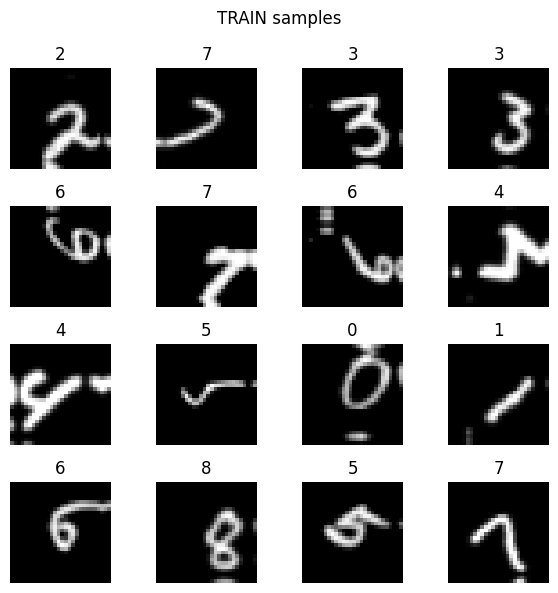

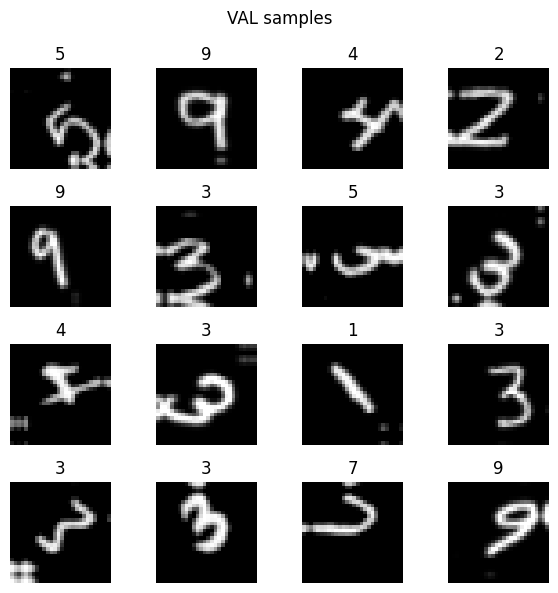

In [ ]:
def show_samples(imgs4d, labels, n=16, title=""):
    plt.figure(figsize=(6,6))
    idx = np.random.choice(len(labels), size=n, replace=False)
    grid = int(np.sqrt(n))
    for i, k in enumerate(idx, start=1):
        plt.subplot(grid, grid, i)
        plt.imshow(imgs4d[k].squeeze(-1), cmap="gray")  # (28,28,1) -> (28,28)
        plt.title(str(labels[k])); plt.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_samples(X_tr4d,  y_tr,  n=16, title="TRAIN samples")
show_samples(X_val4d, y_val, n=16, title="VAL samples")


X_all_flat et X_test_flat sont bien en float32 avec min=0.0, max=1.0 → normalisation cohérente des deux côtés.

Moyennes ~0.142 et écarts-types ~0.233–0.234 → ok aussi (fond sombre, quelques traits clairs).

y_all et y_test ont la bonne forme 1D.

## Répartition des classes


TRAIN (avant split) — total=60000
  classe 0:   5923  ( 9.87%)
  classe 1:   6742  (11.24%)
  classe 2:   5958  ( 9.93%)
  classe 3:   6131  (10.22%)
  classe 4:   5842  ( 9.74%)
  classe 5:   5421  ( 9.04%)
  classe 6:   5918  ( 9.86%)
  classe 7:   6265  (10.44%)
  classe 8:   5851  ( 9.75%)
  classe 9:   5949  ( 9.92%)

TEST  (indépendant) — total=10000
  classe 0:    980  ( 9.80%)
  classe 1:   1135  (11.35%)
  classe 2:   1032  (10.32%)
  classe 3:   1010  (10.10%)
  classe 4:    982  ( 9.82%)
  classe 5:    892  ( 8.92%)
  classe 6:    958  ( 9.58%)
  classe 7:   1028  (10.28%)
  classe 8:    974  ( 9.74%)
  classe 9:   1009  (10.09%)

TRAIN (après split) — total=48000
  classe 0:   4738  ( 9.87%)
  classe 1:   5394  (11.24%)
  classe 2:   4766  ( 9.93%)
  classe 3:   4905  (10.22%)
  classe 4:   4674  ( 9.74%)
  classe 5:   4337  ( 9.04%)
  classe 6:   4734  ( 9.86%)
  classe 7:   5012  (10.44%)
  classe 8:   4681  ( 9.75%)
  classe 9:   4759  ( 9.91%)

VALIDATION — total=12000

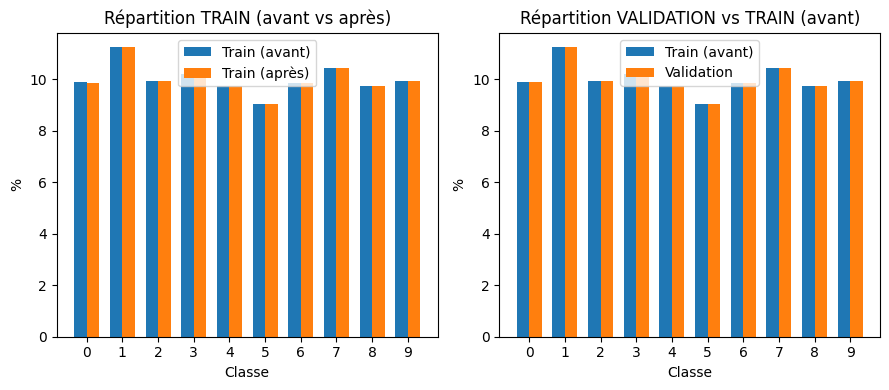

In [ ]:
def class_counts_pct(y, n_classes=10):
    vals, counts = np.unique(y, return_counts=True)
    full_counts = np.zeros(n_classes, dtype=int)
    full_counts[vals] = counts
    pct = full_counts / full_counts.sum() * 100.0
    return full_counts, pct

def print_stats_block(title, y, n_classes=10):
    counts, pct = class_counts_pct(y, n_classes)
    print(f"\n{title} — total={len(y)}")
    for c in range(n_classes):
        print(f"  classe {c}: {counts[c]:6d}  ({pct[c]:5.2f}%)")
    return counts, pct

# ==== Impressions AVANT / APRES ====
# Avant split (ensemble d'entraînement complet + test indépendant)
counts_all,  pct_all  = print_stats_block("TRAIN (avant split)", y_all, n_classes=10)
counts_test, pct_test = print_stats_block("TEST  (indépendant)", y_test, n_classes=10)

# Après split (stratifié) : sous-ensembles train / val
counts_tr,  pct_tr  = print_stats_block("TRAIN (après split)", y_tr,  n_classes=10)
counts_val, pct_val = print_stats_block("VALIDATION",          y_val, n_classes=10)

# Vérif rapide que le stratify a bien conservé les proportions (tolérance 0.2%)
ok = np.allclose(pct_tr, pct_all, atol=0.2) and np.allclose(pct_val, pct_all, atol=0.2)
print("\nStratification OK (≈ mêmes % que l'ensemble train) :", ok)

# ==== Barplots comparatifs ====
x = np.arange(10)
width = 0.35

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.bar(x - width/2, pct_all, width, label="Train (avant)")
plt.bar(x + width/2, pct_tr,  width, label="Train (après)")
plt.xticks(x); plt.xlabel("Classe"); plt.ylabel("%")
plt.title("Répartition TRAIN (avant vs après)"); plt.legend()

plt.subplot(1,2,2)
plt.bar(x - width/2, pct_all, width, label="Train (avant)")
plt.bar(x + width/2, pct_val, width, label="Validation")
plt.xticks(x); plt.xlabel("Classe"); plt.ylabel("%")
plt.title("Répartition VALIDATION vs TRAIN (avant)"); plt.legend()

plt.tight_layout(); plt.show()


On a à peu près 10% pour chaque chiffre ➡ correct. Un peu moins de 5...

## 1er modèle : MLP



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

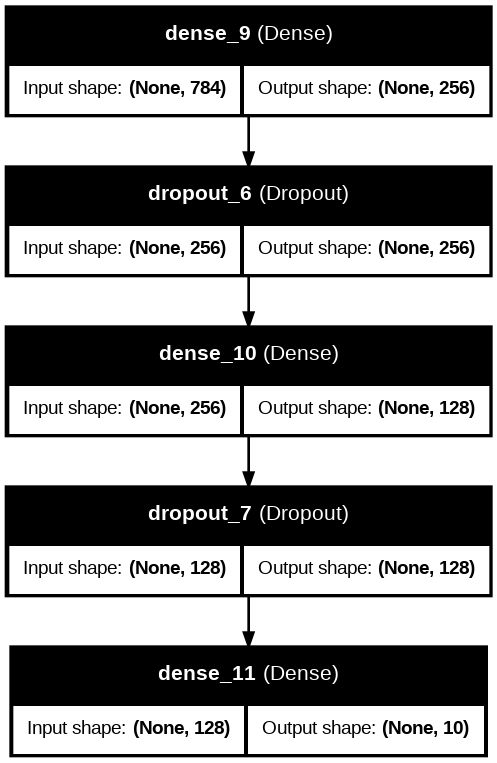

In [ ]:
# === Bloc 1 : Modèle (MLP) ===
mlp = models.Sequential([
    layers.Input(shape=(784,)),           # ou (X_tr_flat.shape[1],)
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

mlp.compile(
    optimizer="rmsprop",                     # ou "adam" mais pas demandé ici
    loss="sparse_categorical_crossentropy",  # labels entiers 0..9
    metrics=["accuracy"]
)

mlp.summary()
plot_model(mlp,show_shapes=True, show_layer_names=True,
           dpi=96, expand_nested=True)


* 200 960 = (784 + 1) * 256
* 32 896 = (256+1) * 128
* 1290 = 10 * (128+1)

## Entraînement & validation

In [ ]:
# === Bloc 2 : Entraînement avec validation ===
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_mlp = mlp.fit(
    X_tr_flat, y_tr,
    validation_data=(X_val_flat, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early],
    verbose=1
)


Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2393 - loss: 2.0851 - val_accuracy: 0.5116 - val_loss: 1.4425
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5061 - loss: 1.4602 - val_accuracy: 0.6437 - val_loss: 1.1172
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5903 - loss: 1.2315 - val_accuracy: 0.6933 - val_loss: 0.9744
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6372 - loss: 1.1081 - val_accuracy: 0.7162 - val_loss: 0.8940
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6618 - loss: 1.0321 - val_accuracy: 0.7183 - val_loss: 0.8798
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6832 - loss: 0.9717 - val_accuracy: 0.7530 - val_loss: 0.7897
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7021 - loss: 0.9172 - val_accuracy: 0.7540 - val_loss: 0.7880
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7122 - loss: 0.8831 - val_accu

## Métriques sur train et validation (loss & accuracy)

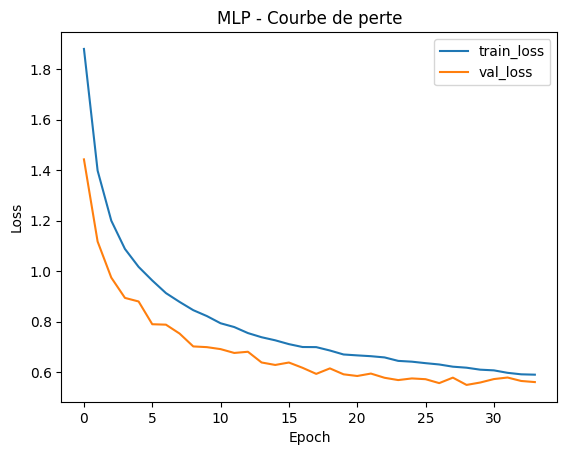

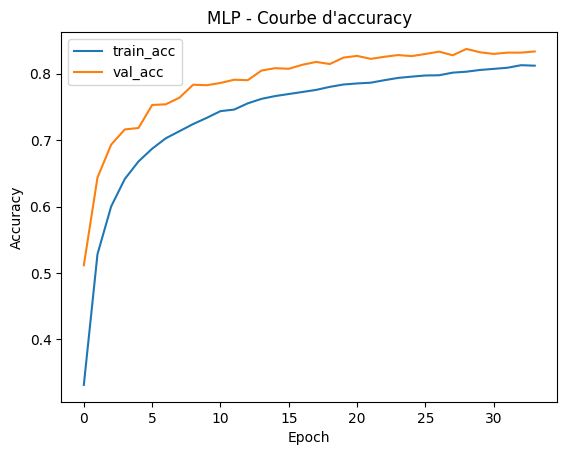

In [ ]:
# === Bloc 3 : Courbes d'apprentissage (MLP) ===

plt.figure()
plt.plot(history_mlp.history["loss"], label="train_loss")
plt.plot(history_mlp.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP - Courbe de perte")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_mlp.history["accuracy"], label="train_acc")
plt.plot(history_mlp.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP - Courbe d'accuracy")
plt.legend()
plt.show()


## Métrique sur le set validation (matrice, prc, roc par classe)

[MLP] Classification report (VALIDATION):
              precision    recall  f1-score   support

           0     0.9017    0.9207    0.9111      1185
           1     0.9209    0.9763    0.9478      1348
           2     0.8058    0.8112    0.8085      1192
           3     0.8588    0.7985    0.8276      1226
           4     0.7936    0.7902    0.7919      1168
           5     0.8255    0.7334    0.7767      1084
           6     0.8238    0.9003    0.8604      1184
           7     0.8320    0.8420    0.8370      1253
           8     0.8078    0.7829    0.7951      1170
           9     0.7848    0.7908    0.7878      1190

    accuracy                         0.8374     12000
   macro avg     0.8355    0.8346    0.8344     12000
weighted avg     0.8368    0.8374    0.8365     12000



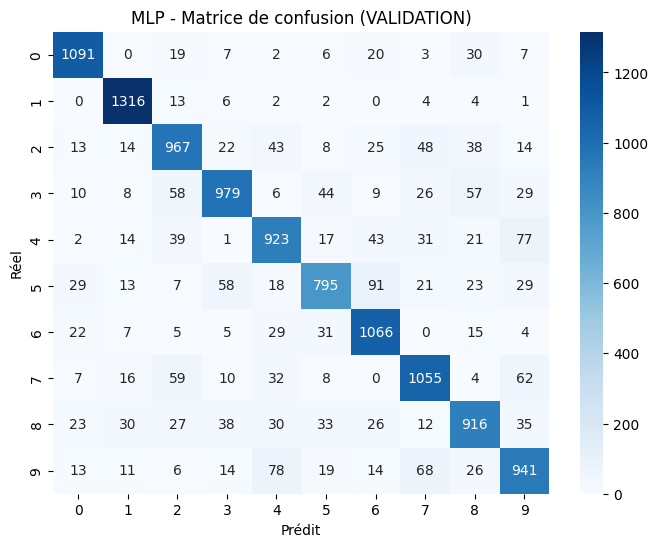

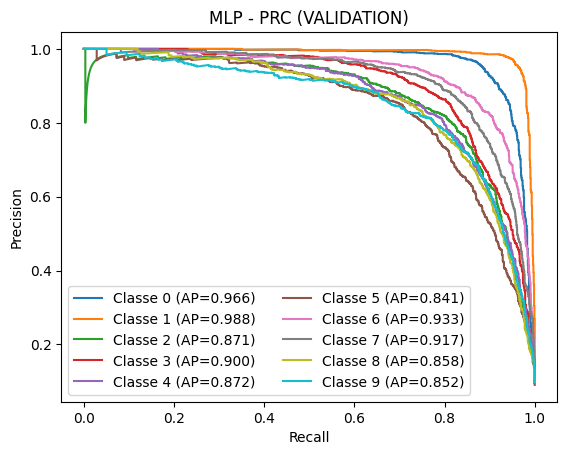

[MLP][VAL] AUC-PR micro=0.9085 | macro=0.8998


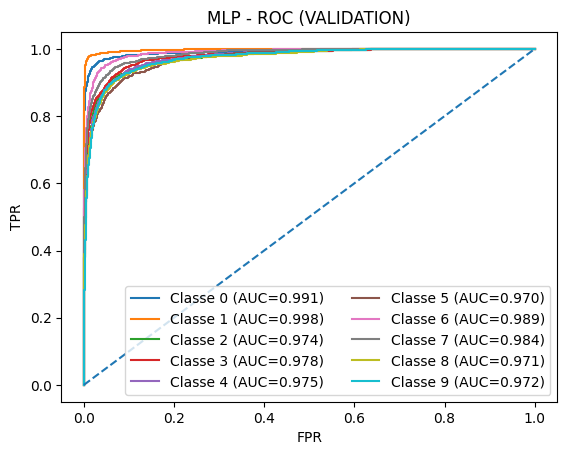

[MLP][VAL] AUC-ROC micro=0.9817 | macro=0.9802


In [ ]:
# === Bloc 4 : Évaluation MLP sur VALIDATION ===
def plot_confusion_matrix(y_true, y_pred, classes, title="Matrice de confusion", cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit"); plt.ylabel("Réel"); plt.title(title); plt.show()

# 1) Report + matrice (VALIDATION)
y_val_proba = mlp.predict(X_val_flat, verbose=0)   # <-- vue MLP
y_val_pred  = y_val_proba.argmax(axis=1)

print("[MLP] Classification report (VALIDATION):")
print(classification_report(y_val, y_val_pred, digits=4))

plot_confusion_matrix(y_val, y_val_pred, classes=list(range(10)),
                      title="MLP - Matrice de confusion (VALIDATION)")

# 2) PRC (AUC-PR) & ROC (AUC-ROC) en one-vs-rest
lb = LabelBinarizer()
lb.fit(list(range(10)))                 # <-- fige 10 classes
y_val_bin = lb.transform(y_val)

# PRC
ap_per_class = []
plt.figure()
for c in range(10):
    precision, recall, _ = precision_recall_curve(y_val_bin[:, c], y_val_proba[:, c])
    ap = average_precision_score(y_val_bin[:, c], y_val_proba[:, c])
    ap_per_class.append(ap)
    plt.plot(recall, precision, label=f"Classe {c} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("MLP - PRC (VALIDATION)")
plt.legend(loc="lower left", ncol=2); plt.show()

ap_micro = average_precision_score(y_val_bin, y_val_proba, average="micro")
ap_macro = float(np.mean(ap_per_class))
print(f"[MLP][VAL] AUC-PR micro={ap_micro:.4f} | macro={ap_macro:.4f}")

# ROC
auc_per_class = []
plt.figure()
for c in range(10):
    fpr, tpr, _ = roc_curve(y_val_bin[:, c], y_val_proba[:, c])
    auc_c = roc_auc_score(y_val_bin[:, c], y_val_proba[:, c])
    auc_per_class.append(auc_c)
    plt.plot(fpr, tpr, label=f"Classe {c} (AUC={auc_c:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("MLP - ROC (VALIDATION)")
plt.legend(loc="lower right", ncol=2); plt.show()

auc_micro = roc_auc_score(y_val_bin, y_val_proba, average="micro")  # <-- pas de multi_class ici
auc_macro = float(np.mean(auc_per_class))
print(f"[MLP][VAL] AUC-ROC micro={auc_micro:.4f} | macro={auc_macro:.4f}")


Precision (classe i) = TPᵢ / (TPᵢ + FPᵢ)

Recall (classe i) = TPᵢ / (TPᵢ + FNᵢ)

F1 (classe i) = 2 × (precision × recall) / (precision + recall)

## Métriques sur le set test

[MLP] Test accuracy = 0.8413 | Test loss = 0.5159

[MLP] Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9112    0.9429    0.9268       980
           1     0.9369    0.9806    0.9582      1135
           2     0.8152    0.8207    0.8180      1032
           3     0.8639    0.7980    0.8296      1010
           4     0.7790    0.7790    0.7790       982
           5     0.8015    0.7422    0.7707       892
           6     0.8309    0.8977    0.8630       958
           7     0.8404    0.8658    0.8529      1028
           8     0.8260    0.7752    0.7998       974
           9     0.7832    0.7839    0.7836      1009

    accuracy                         0.8413     10000
   macro avg     0.8388    0.8386    0.8382     10000
weighted avg     0.8405    0.8413    0.8404     10000



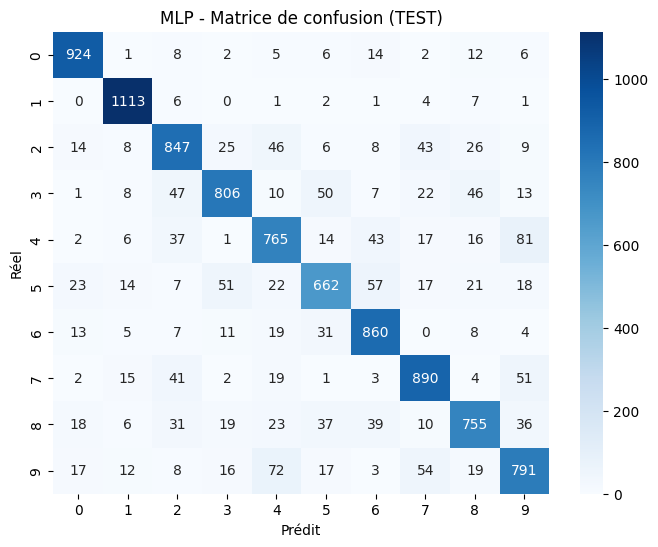

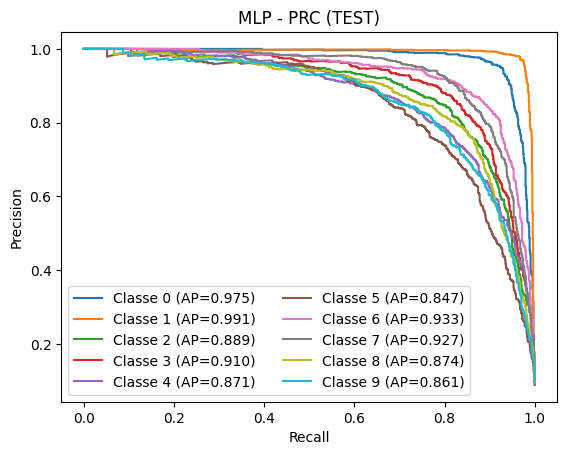

[MLP][TEST] AUC-PR micro=0.9166 | macro=0.9078


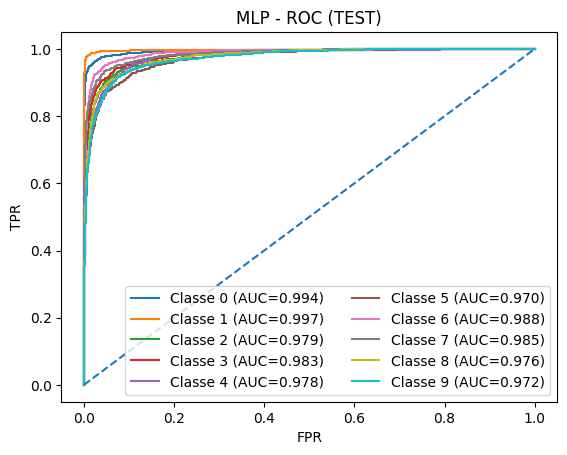

[MLP][TEST] AUC-ROC micro=0.9837 | macro=0.9823


In [ ]:
# === Bloc 5 : Évaluation FINALE MLP sur TEST ===

# 1) Score global
test_loss, test_acc = mlp.evaluate(X_test_flat, y_test, verbose=0)
print(f"[MLP] Test accuracy = {test_acc:.4f} | Test loss = {test_loss:.4f}")

# 2) Report + matrice (TEST)
y_test_proba = mlp.predict(X_test_flat, verbose=0)   # (N_test, 10)
y_test_pred  = y_test_proba.argmax(axis=1)

print("\n[MLP] Classification report (TEST):")
print(classification_report(y_test, y_test_pred, digits=4))

plot_confusion_matrix(y_test, y_test_pred, classes=list(range(10)),
                      title="MLP - Matrice de confusion (TEST)")

# 3) PRC & ROC (one-vs-rest)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(list(range(10)))                 # <-- fige 10 classes
y_test_bin = lb.transform(y_test)

# PRC
ap_per_class = []
plt.figure()
for c in range(10):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, c], y_test_proba[:, c])
    ap = average_precision_score(y_test_bin[:, c], y_test_proba[:, c])
    ap_per_class.append(ap)
    plt.plot(recall, precision, label=f"Classe {c} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("MLP - PRC (TEST)")
plt.legend(loc="lower left", ncol=2); plt.show()

ap_micro = average_precision_score(y_test_bin, y_test_proba, average="micro")
ap_macro = float(np.mean(ap_per_class))
print(f"[MLP][TEST] AUC-PR micro={ap_micro:.4f} | macro={ap_macro:.4f}")

# ROC
auc_per_class = []
plt.figure()
for c in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, c], y_test_proba[:, c])
    auc_c = roc_auc_score(y_test_bin[:, c], y_test_proba[:, c])
    auc_per_class.append(auc_c)
    plt.plot(fpr, tpr, label=f"Classe {c} (AUC={auc_c:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("MLP - ROC (TEST)")
plt.legend(loc="lower right", ncol=2); plt.show()

auc_micro = roc_auc_score(y_test_bin, y_test_proba, average="micro")  # <-- sans multi_class
auc_macro = float(np.mean(auc_per_class))
print(f"[MLP][TEST] AUC-ROC micro={auc_micro:.4f} | macro={auc_macro:.4f}")


## 2e modèle : CNN

In [ ]:
# === Bloc 1 : Modèle (CNN) ===

cnn = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.GlobalAveragePooling2D(),       # <--- au lieu de Flatten()
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])


cnn.compile(
    optimizer="rmsprop",                     # comme le MLP pour comparer proprement
    loss="sparse_categorical_crossentropy",  # labels entiers 0..9
    metrics=["accuracy"]
)

cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,642 (272.04 KB)

 Trainable params: 69,642 (272.04 KB)

 Non-trainable params: 0 (0.00 B)

Conv2D 32 x (3x3x1+1) = 320
[3, 7]
[2, 5]   → max = 7 "neurone + activé" valeur de feature map after conv

## Entraînement et validation

In [ ]:
# === Bloc 2 : Entraînement avec validation ===
early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_cnn = cnn.fit(
    X_tr4d, y_tr,
    validation_data=(X_val4d, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early],
    verbose=1
)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.1736 - loss: 2.2160 - val_accuracy: 0.2086 - val_loss: 2.0902
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2346 - loss: 2.0381 - val_accuracy: 0.2522 - val_loss: 1.9973
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2615 - loss: 1.9797 - val_accuracy: 0.2428 - val_loss: 1.9949
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3183 - loss: 1.8573 - val_accuracy: 0.2760 - val_loss: 1.9226
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3838 - loss: 1.7045 - val_accuracy: 0.3769 - val_loss: 1.6828
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4566 - loss: 1.5198 - val_accuracy: 0.4342 - val_loss: 1.5470
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5274 - loss: 1.3427 - val_accuracy: 0.5203 - val_loss: 1.3250
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5933 - loss: 1.1860 - val_ac

## Métriques sur train et validation (loss & accuracy)


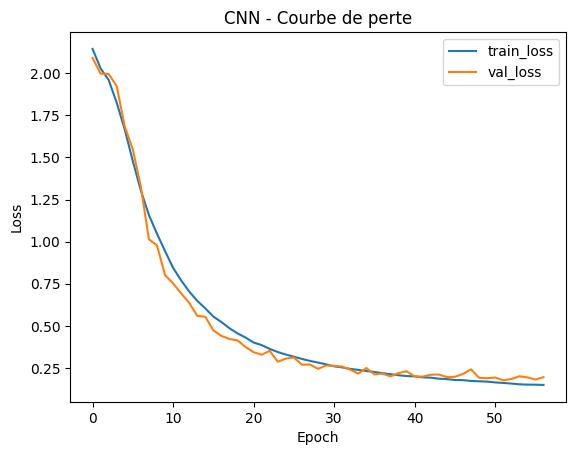

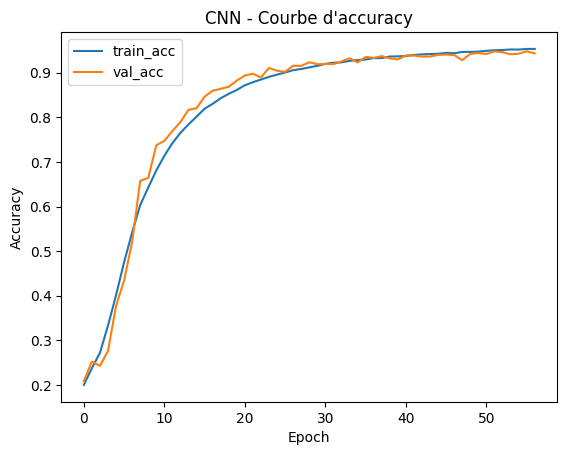

In [ ]:
# === Bloc 3 : Courbes d'apprentissage (MLP) ===
plt.figure()
plt.plot(history_cnn.history["loss"], label="train_loss")
plt.plot(history_cnn.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN - Courbe de perte")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_cnn.history["accuracy"], label="train_acc")
plt.plot(history_cnn.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN - Courbe d'accuracy")
plt.legend()
plt.show()


## Métriques sur set validation (matrice, prc, roc par classe)

[CNN] Classification report (VALIDATION):
              precision    recall  f1-score   support

           0     0.9770    0.9662    0.9716      1185
           1     0.9742    0.9800    0.9771      1348
           2     0.9090    0.9220    0.9155      1192
           3     0.9686    0.9576    0.9631      1226
           4     0.9511    0.9495    0.9503      1168
           5     0.9421    0.9013    0.9213      1084
           6     0.9526    0.9671    0.9598      1184
           7     0.9247    0.9601    0.9421      1253
           8     0.9337    0.9385    0.9361      1170
           9     0.9470    0.9303    0.9385      1190

    accuracy                         0.9482     12000
   macro avg     0.9480    0.9472    0.9475     12000
weighted avg     0.9483    0.9482    0.9481     12000



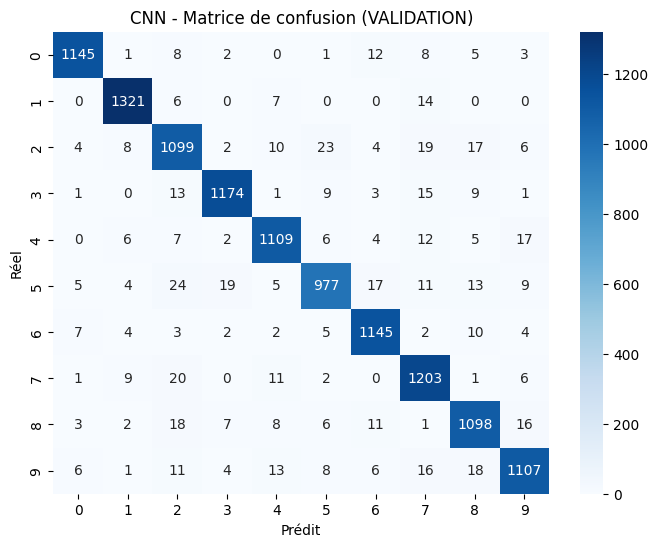

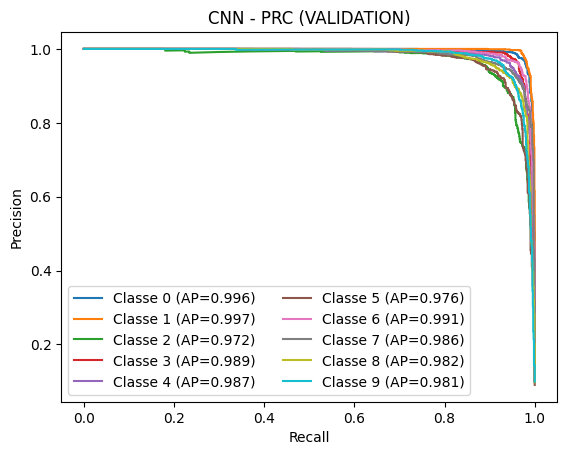

[CNN][VAL] AUC-PR micro=0.9867 | macro=0.9858


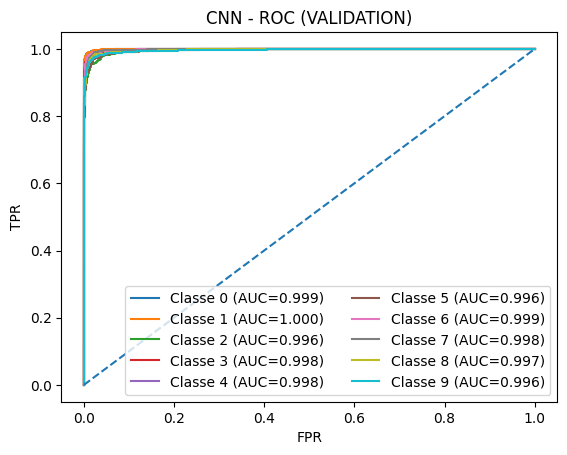

[CNN][VAL] AUC-ROC micro=0.9978 | macro=0.9976


In [ ]:
# === Bloc 4 : Évaluation CNN sur VALIDATION ===

# 1) Report + matrice (VALIDATION)
y_val_proba = cnn.predict(X_val4d, verbose=0)   # <-- vue CNN
y_val_pred  = y_val_proba.argmax(axis=1)

print("[CNN] Classification report (VALIDATION):")
print(classification_report(y_val, y_val_pred, digits=4))

plot_confusion_matrix(y_val, y_val_pred, classes=list(range(10)),
                      title="CNN - Matrice de confusion (VALIDATION)")

# 2) PRC (AUC-PR) & ROC (AUC-ROC) en one-vs-rest
lb = LabelBinarizer()
lb.fit(list(range(10)))                 # <-- fige 10 classes
y_val_bin = lb.transform(y_val)

# PRC
ap_per_class = []
plt.figure()
for c in range(10):
    precision, recall, _ = precision_recall_curve(y_val_bin[:, c], y_val_proba[:, c])
    ap = average_precision_score(y_val_bin[:, c], y_val_proba[:, c])
    ap_per_class.append(ap)
    plt.plot(recall, precision, label=f"Classe {c} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("CNN - PRC (VALIDATION)")
plt.legend(loc="lower left", ncol=2); plt.show()

ap_micro = average_precision_score(y_val_bin, y_val_proba, average="micro")
ap_macro = float(np.mean(ap_per_class))
print(f"[CNN][VAL] AUC-PR micro={ap_micro:.4f} | macro={ap_macro:.4f}")

# ROC
auc_per_class = []
plt.figure()
for c in range(10):
    fpr, tpr, _ = roc_curve(y_val_bin[:, c], y_val_proba[:, c])
    auc_c = roc_auc_score(y_val_bin[:, c], y_val_proba[:, c])
    auc_per_class.append(auc_c)
    plt.plot(fpr, tpr, label=f"Classe {c} (AUC={auc_c:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("CNN - ROC (VALIDATION)")
plt.legend(loc="lower right", ncol=2); plt.show()

auc_micro = roc_auc_score(y_val_bin, y_val_proba, average="micro")  # <-- pas de multi_class ici
auc_macro = float(np.mean(auc_per_class))
print(f"[CNN][VAL] AUC-ROC micro={auc_micro:.4f} | macro={auc_macro:.4f}")


## Métriques sur le set test

[CNN] Test accuracy = 0.9527 | Test loss = 0.1611

[CNN] Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9763    0.9673    0.9718       980
           1     0.9682    0.9930    0.9804      1135
           2     0.9176    0.9283    0.9229      1032
           3     0.9606    0.9663    0.9635      1010
           4     0.9522    0.9532    0.9527       982
           5     0.9561    0.9036    0.9291       892
           6     0.9634    0.9614    0.9624       958
           7     0.9404    0.9523    0.9464      1028
           8     0.9477    0.9497    0.9487       974
           9     0.9453    0.9425    0.9439      1009

    accuracy                         0.9527     10000
   macro avg     0.9528    0.9518    0.9522     10000
weighted avg     0.9527    0.9527    0.9526     10000



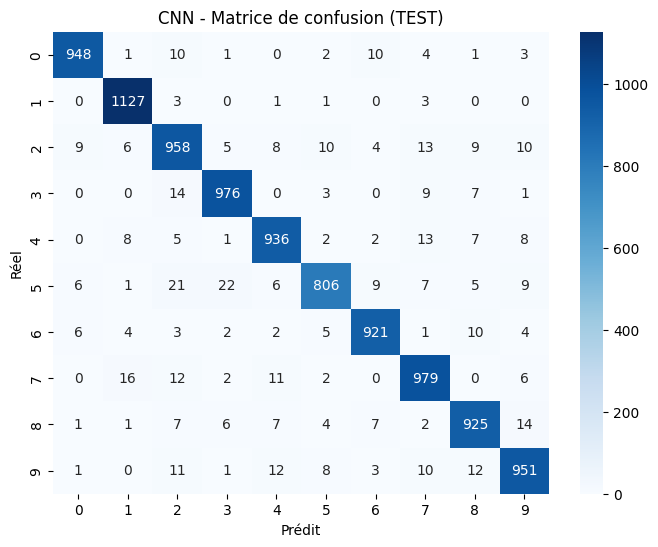

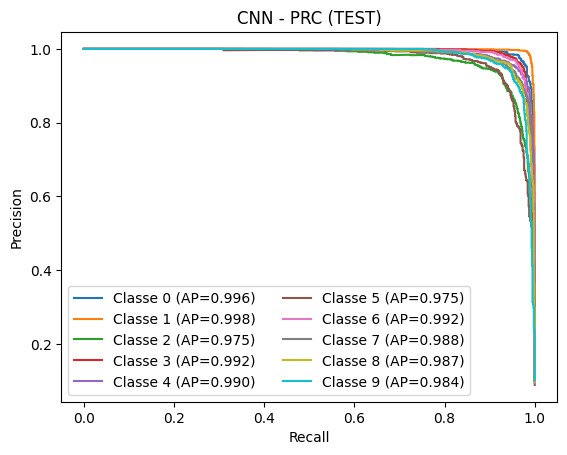

[CNN][TEST] AUC-PR micro=0.9886 | macro=0.9877


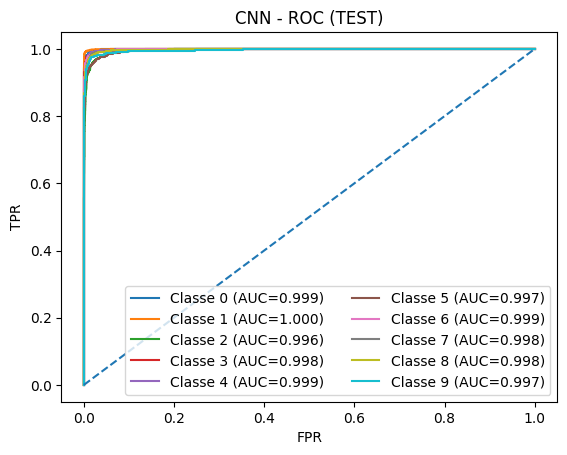

[CNN][TEST] AUC-ROC micro=0.9983 | macro=0.9981


In [ ]:
# === Bloc 5 : Évaluation FINALE CNN sur TEST ===

# 1) Score global
test_loss, test_acc = cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f"[CNN] Test accuracy = {test_acc:.4f} | Test loss = {test_loss:.4f}")

# 2) Report + matrice (TEST)
y_test_proba = cnn.predict(X_test_cnn, verbose=0)   # (N_test, 10)
y_test_pred  = y_test_proba.argmax(axis=1)

print("\n[CNN] Classification report (TEST):")
print(classification_report(y_test, y_test_pred, digits=4))

plot_confusion_matrix(y_test, y_test_pred, classes=list(range(10)),
                      title="CNN - Matrice de confusion (TEST)")

# 3) PRC & ROC (one-vs-rest)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(list(range(10)))                 # <-- fige 10 classes
y_test_bin = lb.transform(y_test)

# PRC
ap_per_class = []
plt.figure()
for c in range(10):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, c], y_test_proba[:, c])
    ap = average_precision_score(y_test_bin[:, c], y_test_proba[:, c])
    ap_per_class.append(ap)
    plt.plot(recall, precision, label=f"Classe {c} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("CNN - PRC (TEST)")
plt.legend(loc="lower left", ncol=2); plt.show()

ap_micro = average_precision_score(y_test_bin, y_test_proba, average="micro")
ap_macro = float(np.mean(ap_per_class))
print(f"[CNN][TEST] AUC-PR micro={ap_micro:.4f} | macro={ap_macro:.4f}")

# ROC
auc_per_class = []
plt.figure()
for c in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, c], y_test_proba[:, c])
    auc_c = roc_auc_score(y_test_bin[:, c], y_test_proba[:, c])
    auc_per_class.append(auc_c)
    plt.plot(fpr, tpr, label=f"Classe {c} (AUC={auc_c:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("CNN - ROC (TEST)")
plt.legend(loc="lower right", ncol=2); plt.show()

auc_micro = roc_auc_score(y_test_bin, y_test_proba, average="micro")  # <-- sans multi_class
auc_macro = float(np.mean(auc_per_class))
print(f"[CNN][TEST] AUC-ROC micro={auc_micro:.4f} | macro={auc_macro:.4f}")
